In [13]:
import os
import time
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Subset

# ===========================================================================
# 1. CONFIGURATION & DEVICE
# ===========================================================================
PROJECT_ROOT = "/home/ubuntu/nutrition_data" 
DATA_DIR = os.path.join(PROJECT_ROOT, "public_datasets")
CHECKPOINT_PATH = "checkpoints_tesla_final/BEST_TESLA.pth"
BATCH_SIZE = 32
NUM_CLASSES = 101  # Food-101 has 101 classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using Device: {DEVICE}")
os.makedirs(DATA_DIR, exist_ok=True)

# ===========================================================================
# 2. DATA DOWNLOAD & SETUP
# ===========================================================================
print("\n--- STEP 2: PREPARING DATA ---")
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats, inplace=True)
])

valid_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

print("Checking/Downloading Food-101 Dataset...")
train_ds = torchvision.datasets.Food101(root=DATA_DIR, split='train', transform=train_tfms, download=True)
valid_ds = torchvision.datasets.Food101(root=DATA_DIR, split='test', transform=valid_tfms, download=True)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Data Ready. Train: {len(train_ds)}, Val: {len(valid_ds)}")

# ===========================================================================
# 3. MODEL ARCHITECTURE
# ===========================================================================
print("\n--- STEP 3: BUILDING HYDRANET ---")

# A. The Original ResNetUNet (Needed to load weights)
class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()
        res = models.resnet50(weights=None) 
        self.enc0 = nn.Sequential(res.conv1, res.bn1, res.relu)
        self.pool = res.maxpool
        self.e1 = res.layer1
        self.e2 = res.layer2
        self.e3 = res.layer3
        self.e4 = res.layer4
        
        self.up4 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.c4 = nn.Sequential(nn.Conv2d(2048, 1024, 3, 1, 1), nn.ReLU(True))
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.c3 = nn.Sequential(nn.Conv2d(1024, 512, 3, 1, 1), nn.ReLU(True))
        self.up2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.c2 = nn.Sequential(nn.Conv2d(512, 256, 3, 1, 1), nn.ReLU(True))
        self.up1 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.c1 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1), nn.ReLU(True))
        self.up0 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.c0 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(True))
        self.out = nn.Conv2d(32, 1, 1)

# B. The New HydraNet (Wrapper)
class FoodHydraNet(nn.Module):
    def __init__(self, original_model, num_classes=101):
        super(FoodHydraNet, self).__init__()
        
        # --- Shared Encoder (Body) ---
        self.enc0 = original_model.enc0
        self.pool = original_model.pool
        self.e1 = original_model.e1
        self.e2 = original_model.e2
        self.e3 = original_model.e3
        self.e4 = original_model.e4
        
        # --- Head 1: Volume (Depth Decoder) ---
        self.up4 = original_model.up4
        self.c4 = original_model.c4
        self.up3 = original_model.up3
        self.c3 = original_model.c3
        self.up2 = original_model.up2
        self.c2 = original_model.c2
        self.up1 = original_model.up1
        self.c1 = original_model.c1
        self.up0 = original_model.up0
        self.c0 = original_model.c0
        self.depth_out = original_model.out
        
        # FREEZE Body & Depth Head
        for param in self.parameters():
            param.requires_grad = False
        
        # --- Head 2: Identity (Classification) ---
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.class_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        # Unfreeze classification head
        for param in self.class_head.parameters():
            param.requires_grad = True

    def forward(self, x, return_depth=False):
        # 1. Shared Encoder (Body)
        s0 = self.enc0(x)
        s0p = self.pool(s0)
        s1 = self.e1(s0p)
        s2 = self.e2(s1)
        s3 = self.e3(s2)
        b = self.e4(s3)
        
        # 2. Classification Head (Always run)
        pooled = self.avgpool(b)
        flat = self.flatten(pooled)
        class_logits = self.class_head(flat)
        
        # 3. Depth Head (Run only if requested)
        if return_depth:
            # Block 4: 2048 -> 1024
            d = self.up4(b)
            d = torch.cat([d, s3], dim=1)  # 1024 + 1024 = 2048
            d = self.c4(d)
            
            # Block 3: 1024 -> 512
            d = self.up3(d)
            d = torch.cat([d, s2], dim=1)  # 512 + 512 = 1024
            d = self.c3(d)
            
            # Block 2: 512 -> 256
            d = self.up2(d)
            d = torch.cat([d, s1], dim=1)  # 256 + 256 = 512
            d = self.c2(d)
            
            # Block 1: 256 -> 64
            d = self.up1(d)
            d = torch.cat([d, s0], dim=1)  # 64 + 64 = 128 (s0, NOT s0p!)
            d = self.c1(d)
            
            # Block 0: 64 -> 32
            d = self.up0(d)
            d = self.c0(d)
            
            # Final depth output
            depth_pred = self.depth_out(d)
            
            return class_logits, depth_pred
        
        return class_logits

# 4. Load Weights & Build
base_model = ResNetUNet()
if os.path.exists(CHECKPOINT_PATH):
    base_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
    print("Loaded BEST_TESLA.pth")
else:
    print("Checkpoint not found. Using random weights (OK for testing code).")

model = FoodHydraNet(base_model, num_classes=NUM_CLASSES).to(DEVICE)
print("HydraNet model built successfully!")

Using Device: cuda

--- STEP 2: PREPARING DATA ---
Checking/Downloading Food-101 Dataset...
Data Ready. Train: 75750, Val: 25250

--- STEP 3: BUILDING HYDRANET ---


/tmp/ipykernel_2961/1252503938.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))


Loaded BEST_TESLA.pth
HydraNet model built successfully!


Sample Labels: ['bread_pudding', 'escargots', 'pancakes', 'spaghetti_bolognese', 'scallops']


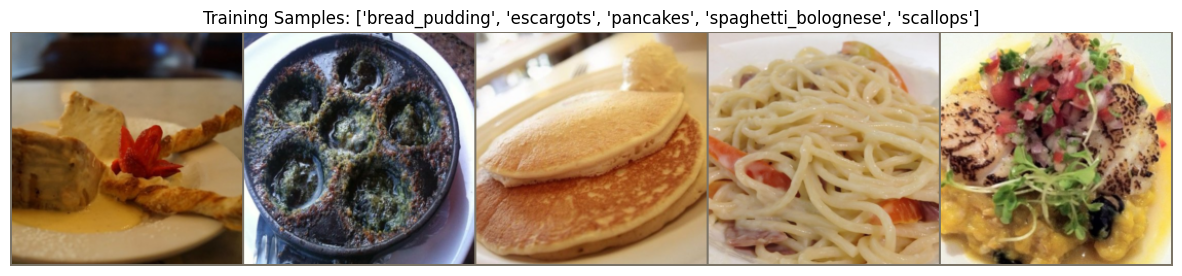

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(inp, title=None):
    """Display a tensor as an image."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from Tensor (C,H,W) to Image (H,W,C)
    
    # Denormalize (Undo the stats we applied in transforms)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    # Clip to ensure colors are valid [0,1]
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(15, 5))
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 1. Get a batch of training data
# 'next(iter(train_dl))' grabs the first 32 images
inputs, classes = next(iter(train_dl))

# 2. Select the first 5 images to display
num_images = 5
sample_inputs = inputs[:num_images]
sample_classes = classes[:num_images]

# 3. Create a grid
out = torchvision.utils.make_grid(sample_inputs, nrow=5)

# 4. Get class names
class_names = [train_ds.classes[x] for x in sample_classes]

# 5. Show them
print(f"Sample Labels: {class_names}")
imshow(out, title=f"Training Samples: {class_names}")

In [2]:
# ===========================================================================
# 4. TRAINING LOOP
# ===========================================================================
print("\n--- STEP 4: TRAINING HEAD 2 ---")

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_model(model, epochs=3):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Train
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_dl):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            
            outputs = model(inputs) # Returns class logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += inputs.size(0)
            
            if i % 100 == 0:
                print(f"   Batch {i}: Loss {loss.item():.4f}")
                
        print(f"   Train Acc: {correct.double()/total:.4f}")
        
        # Validate
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valid_dl:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
                val_total += inputs.size(0)
                
        print(f"   Val Acc: {val_correct.double()/val_total:.4f}")
        
        # Save
        torch.save(model.state_dict(), "checkpoints_tesla_final/BEST_HYDRANET.pth")
        print("   Saved checkpoint.")

# Run Training
train_model(model, epochs=5)


--- STEP 4: TRAINING HEAD 2 ---
Epoch 1/5
   Batch 0: Loss 4.5857
   Batch 100: Loss 4.2450
   Batch 200: Loss 3.6963
   Batch 300: Loss 3.5347
   Batch 400: Loss 3.2461
   Batch 500: Loss 2.7574
   Batch 600: Loss 3.1272
   Batch 700: Loss 3.2381
   Batch 800: Loss 2.5150
   Batch 900: Loss 2.7304
   Batch 1000: Loss 2.6371
   Batch 1100: Loss 2.8327
   Batch 1200: Loss 2.6326
   Batch 1300: Loss 2.6171
   Batch 1400: Loss 2.1814
   Batch 1500: Loss 2.5033
   Batch 1600: Loss 2.9927
   Batch 1700: Loss 2.5206
   Batch 1800: Loss 2.6576
   Batch 1900: Loss 2.6501
   Batch 2000: Loss 3.0555
   Batch 2100: Loss 2.7937
   Batch 2200: Loss 2.3934
   Batch 2300: Loss 2.1227
   Train Acc: 0.3021
   Val Acc: 0.5105
   Saved checkpoint.
Epoch 2/5
   Batch 0: Loss 2.9492
   Batch 100: Loss 2.3955
   Batch 200: Loss 1.8520
   Batch 300: Loss 2.2215
   Batch 400: Loss 2.7817
   Batch 500: Loss 2.1405
   Batch 600: Loss 2.1102
   Batch 700: Loss 1.6777
   Batch 800: Loss 2.3551
   Batch 900: Loss

In [15]:
# Load the trained classification head weights
model.load_state_dict(torch.load("checkpoints_tesla_final/BEST_HYDRANET.pth", map_location=DEVICE))
print("Loaded trained HydraNet weights")

Loaded trained HydraNet weights


/tmp/ipykernel_2961/2441668980.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints_tesla_final/BEST_HYDRANET.pth", map_location

In [16]:
import os
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ===========================================================================
# STEP 5: BENCHMARK CLASSIFICATION ACCURACY
# ===========================================================================

def benchmark_head2(model, loader, device):
    """
    Benchmark the classification head (Head 2) of HydraNet.
    
    Tests Top-1 and Top-5 accuracy on Food-101 validation set.
    
    Args:
        model: Trained FoodHydraNet
        loader: DataLoader (validation set)
        device: torch.device
    
    Returns:
        acc_1: Top-1 accuracy (%)
        acc_5: Top-5 accuracy (%)
    """
    model.eval()
    correct_1 = 0
    correct_5 = 0
    total = 0
    
    print(f"\n{'='*70}")
    print("STEP 5: BENCHMARKING CLASSIFICATION ACCURACY")
    print(f"{'='*70}\n")
    print("Running inference on validation set...")
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Get model output
            # Handle both cases: (depth, class) or just class
            outputs = model(inputs)
            
            if isinstance(outputs, tuple):
                # Model returns (depth, class_logits)
                _, class_logits = outputs
            else:
                # Model returns only class_logits
                class_logits = outputs
            
            # Top-1 Accuracy
            _, pred_1 = torch.max(class_logits, 1)
            correct_1 += (pred_1 == labels).sum().item()
            
            # Top-5 Accuracy
            _, pred_5 = class_logits.topk(5, dim=1, largest=True, sorted=True)
            labels_expanded = labels.view(-1, 1).expand_as(pred_5)
            correct_top5 = (pred_5 == labels_expanded).any(dim=1)
            correct_5 += correct_top5.sum().item()
            
            total += inputs.size(0)
            
            # Progress update
            if i % 100 == 0 and i > 0:
                print(f"   Processed {i}/{len(loader)} batches ({total:,} samples)...")
    
    # Calculate accuracies
    acc_1 = 100.0 * correct_1 / total
    acc_5 = 100.0 * correct_5 / total
    
    # Print results
    print(f"\n{'='*70}")
    print(f"🏆 FINAL RESULTS (on {total:,} samples):")
    print(f"{'='*70}")
    print(f"   Top-1 Accuracy: {acc_1:.2f}%")
    print(f"   Top-5 Accuracy: {acc_5:.2f}%")
    print(f"{'='*70}\n")
    
    return acc_1, acc_5




In [17]:
# Run the benchmark
acc_1, acc_5 = benchmark_head2(model, valid_dl, DEVICE)


STEP 5: BENCHMARKING CLASSIFICATION ACCURACY

Running inference on validation set...
   Processed 100/790 batches (3,232 samples)...
   Processed 200/790 batches (6,432 samples)...
   Processed 300/790 batches (9,632 samples)...
   Processed 400/790 batches (12,832 samples)...
   Processed 500/790 batches (16,032 samples)...
   Processed 600/790 batches (19,232 samples)...
   Processed 700/790 batches (22,432 samples)...

🏆 FINAL RESULTS (on 25,250 samples):
   Top-1 Accuracy: 58.30%
   Top-5 Accuracy: 83.58%



In [24]:
import os
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# ===========================================================================
# STEP 6: COMPLETE NUTRITION ESTIMATION DEMO
# ===========================================================================

# Physics-Informed Database (Density g/cm³, Energy kcal/g)
PHYSICS_DB = {
    # Burgers & Sandwiches
    "hamburger": (0.9, 2.5),
    "hot_dog": (0.85, 2.9),
    "club_sandwich": (0.7, 2.2),
    
    # Pizza & Italian
    "pizza": (0.8, 2.7),
    "lasagna": (1.0, 1.5),
    "spaghetti_carbonara": (0.95, 1.8),
    "spaghetti_bolognese": (0.95, 1.3),
    "ravioli": (1.0, 1.7),
    
    # Asian
    "sushi": (1.1, 1.4),
    "ramen": (1.0, 0.7),
    "pad_thai": (0.85, 1.5),
    "fried_rice": (0.9, 1.7),
    "spring_rolls": (0.7, 2.5),
    "dumplings": (1.0, 2.0),
    "takoyaki": (0.8, 2.0),
    
    # Breakfast
    "pancakes": (0.6, 2.3),
    "waffles": (0.5, 2.9),
    "french_toast": (0.7, 2.0),
    "omelette": (0.9, 1.5),
    
    # Healthy
    "caesar_salad": (0.4, 0.9),
    "greek_salad": (0.5, 0.8),
    "caprese_salad": (0.8, 1.2),
    
    # Desserts
    "ice_cream": (0.6, 2.1),
    "chocolate_cake": (0.8, 3.5),
    "apple_pie": (0.7, 2.5),
    "cheesecake": (0.9, 3.2),
    
    # Snacks
    "french_fries": (0.5, 3.1),
    "chicken_wings": (0.8, 2.5),
    "nachos": (0.6, 3.0),
    
    # Meat
    "steak": (1.1, 2.5),
    "grilled_salmon": (1.05, 2.0),
    "fried_chicken": (0.85, 2.7),
    "pork_chop": (1.0, 2.4),
    
    # Soup
    "hot_and_sour_soup": (1.0, 0.5),
    "miso_soup": (1.0, 0.4),
    "clam_chowder": (1.0, 0.9),
    
    # Default for unknown foods
    "default": (0.8, 2.0)
}


def predict_meal_calories(image_path, model, class_names, device):
    """
    Complete pipeline: Image → Volume + Classification → Calories
    
    Args:
        image_path: Path to food image
        model: Trained FoodHydraNet
        class_names: List of Food-101 class names
        device: torch.device
    
    Returns:
        dict with prediction results
    """
    
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"❌ Error: Image not found at '{image_path}'")
        return None
    
    print(f"\n{'='*70}")
    print("STEP 6: NUTRITION ESTIMATION DEMO")
    print(f"{'='*70}\n")
    print(f"Processing: {image_path}\n")
    
    # =========================================================================
    # 1. Load and Preprocess Image
    # =========================================================================
    print("1. Loading and preprocessing image...")
    
    try:
        # Load image
        img_pil = Image.open(image_path).convert('RGB')
        img_np = np.array(img_pil)
        
        # Apply same transforms as training
        stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(*stats)
        ])
        
        input_tensor = transform(img_pil).unsqueeze(0).to(device)
        print(f"   ✅ Image loaded: {input_tensor.shape}\n")
        
    except Exception as e:
        print(f"   ❌ Error loading image: {e}")
        return None
    
    # =========================================================================
    # 2. Run Model Inference
    # =========================================================================
    print("2. Running HydraNet inference...")
    
    model.eval()
    with torch.no_grad():
        try:
            outputs = model(input_tensor, return_depth=True)
            if isinstance(outputs, tuple):
                class_logits, depth_map = outputs
                has_depth = True
            else:
                class_logits = outputs
                depth_map = None
                has_depth = False
        except TypeError:
            outputs = model(input_tensor)
            if isinstance(outputs, tuple):
                class_logits, depth_map = outputs
                has_depth = True
            else:
                class_logits = outputs
                depth_map = None
                has_depth = False
    
    print(f"   ✅ Inference complete\n")
    
    # =========================================================================
    # 3. Process Classification (Food Identity)
    # =========================================================================
    print("3. Identifying food...")
    
    probs = F.softmax(class_logits, dim=1)
    top5_probs, top5_indices = probs.topk(5, dim=1)
    
    top_prob = top5_probs[0, 0].item()
    top_idx = top5_indices[0, 0].item()
    food_name = class_names[top_idx]
    
    print(f"   Detected: {food_name}")
    print(f"   Confidence: {top_prob*100:.1f}%\n")
    
    print("   Top 5 predictions:")
    for i in range(5):
        name = class_names[top5_indices[0, i].item()]
        prob = top5_probs[0, i].item()
        marker = "→" if i == 0 else " "
        print(f"   {marker} {i+1}. {name:30s} {prob*100:5.1f}%")
    print()
    
    # =========================================================================
    # 4. Estimate Volume from Depth
    # =========================================================================
    print("4. Estimating volume...")

    if has_depth and depth_map is not None:
        # Get depth predictions
        pred_depth = depth_map[0, 0].cpu().numpy()
        
        # Check actual depth range
        depth_min = pred_depth.min()
        depth_max = pred_depth.max()
        depth_mean = pred_depth.mean()
        print(f"   Depth range: {depth_min:.2f} - {depth_max:.2f} (mean: {depth_mean:.2f})")
        
        # Use relative depth to estimate volume
        # Normalize depth to 0-1 range
        depth_normalized = (pred_depth - depth_min) / (depth_max - depth_min + 1e-6)
        
        # Invert so closer objects (food) have higher values
        depth_inverted = 1.0 - depth_normalized
        
        # Threshold to segment food region (top 50% closest pixels)
        food_mask = depth_inverted > 0.5
        
        # Estimate volume based on food region
        pixel_size_cm = 0.1
        avg_food_depth_cm = 4.0
        
        food_pixels = food_mask.sum()
        if food_pixels > 100:
            # Volume = area × height
            area_cm2 = food_pixels * (pixel_size_cm ** 2)
            volume_cm3 = area_cm2 * avg_food_depth_cm
            
            # Scale based on depth variance
            depth_variance = depth_inverted[food_mask].std()
            volume_cm3 = volume_cm3 * (1 + depth_variance * 2)
            
            # Clamp to reasonable range
            volume_cm3 = np.clip(volume_cm3, 50, 1500)
            
            print(f"   Method: Depth-based estimation")
            print(f"   Food pixels: {food_pixels}")
        else:
            volume_cm3 = 250.0
            print(f"   Method: Default (insufficient food region)")
    else:
        volume_cm3 = 250.0
        pred_depth = None
        print(f"   Method: Default (depth not available)")

    print(f"   Volume: {volume_cm3:.0f} cm³")
    
    # =========================================================================
    # 5. Calculate Mass & Calories
    # =========================================================================
    print("\n5. Calculating Mass & Calories...")
    
    # Get physics values from database
    food_key = food_name.lower().replace(' ', '_')
    density, energy = PHYSICS_DB.get(food_key, PHYSICS_DB["default"])
    
    # Calculate mass and calories
    mass_g = volume_cm3 * density
    calories = mass_g * energy
    
    print(f"   Food: {food_name}")
    print(f"   Physics: {density} g/cm³ | {energy} kcal/g")
    print(f"   Calculated Mass: {mass_g:.0f} g")
    print(f"   Total Calories: {calories:.0f} kcal\n")
    
    # =========================================================================
    # 6. Create Visualization
    # =========================================================================
    print("6. Creating visualization...")
    
    img_display = cv2.resize(img_np, (224, 224))
    
    fig, axs = plt.subplots(1, 3, figsize=(14, 5))
    
    # Panel 1: Original Image
    axs[0].imshow(img_display)
    axs[0].set_title(f"Food: {food_name}\n({top_prob*100:.1f}%)", fontsize=12, fontweight='bold')
    axs[0].axis('off')
    
    # Panel 2: Depth Map
    if pred_depth is not None:
        depth_vis = axs[1].imshow(pred_depth, cmap='magma')
        plt.colorbar(depth_vis, ax=axs[1], fraction=0.046, pad=0.04)
        axs[1].set_title(f"Volume: {volume_cm3:.0f} cm³", fontsize=12, fontweight='bold')
    else:
        axs[1].text(0.5, 0.5, 'Depth Not Available', ha='center', va='center', fontsize=12)
        axs[1].set_title("Depth Map", fontsize=12, fontweight='bold')
    axs[1].axis('off')
    
    # Panel 3: Physics Report
    axs[2].axis('off')
    
    report_text = f"""
    PHYSICS REPORT
    
    Volume:   {volume_cm3:.0f} cm³
    Density:  {density} g/cm³
    --------------------
    MASS:     {mass_g:.0f} g
    --------------------
    
    Energy:   {energy} kcal/g
    --------------------
    CALORIES: {calories:.0f} kcal
    --------------------
    """
    
    axs[2].text(0.1, 0.5, report_text,
               fontsize=11,
               family='monospace',
               verticalalignment='center',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))
    axs[2].set_title("Nutritional Info", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig("nutrition_result.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"   ✅ Saved to 'nutrition_result.png'\n")
    
    # =========================================================================
    # 7. Final Summary
    # =========================================================================
    print(f"{'='*70}")
    print(f"✅ RESULT: {food_name} | {volume_cm3:.0f} cm³ | {mass_g:.0f}g | {calories:.0f} kcal")
    print(f"{'='*70}\n")
    
    return {
        'food_name': food_name,
        'confidence': top_prob,
        'volume_cm3': volume_cm3,
        'mass_g': mass_g,
        'calories': calories,
        'density': density,
        'energy': energy,
        'has_depth': has_depth
    }

Testing on: /home/ubuntu/nutrition_data/public_datasets/food-101/images/ice_cream/1971651.jpg

STEP 6: NUTRITION ESTIMATION DEMO

Processing: /home/ubuntu/nutrition_data/public_datasets/food-101/images/ice_cream/1971651.jpg

1. Loading and preprocessing image...
   ✅ Image loaded: torch.Size([1, 3, 224, 224])

2. Running HydraNet inference...
   ✅ Inference complete

3. Identifying food...
   Detected: ice_cream
   Confidence: 25.1%

   Top 5 predictions:
   → 1. ice_cream                       25.1%
     2. chocolate_mousse                18.1%
     3. tiramisu                        14.4%
     4. creme_brulee                     7.4%
     5. frozen_yogurt                    5.3%

4. Estimating volume...
   Depth range: 2.34 - 4.79 (mean: 3.64)
   Method: Depth-based estimation
   Food pixels: 26870
   Volume: 1145 cm³

5. Calculating Mass & Calories...
   Food: ice_cream
   Physics: 0.6 g/cm³ | 2.1 kcal/g
   Calculated Mass: 687 g
   Total Calories: 1442 kcal

6. Creating visualizati

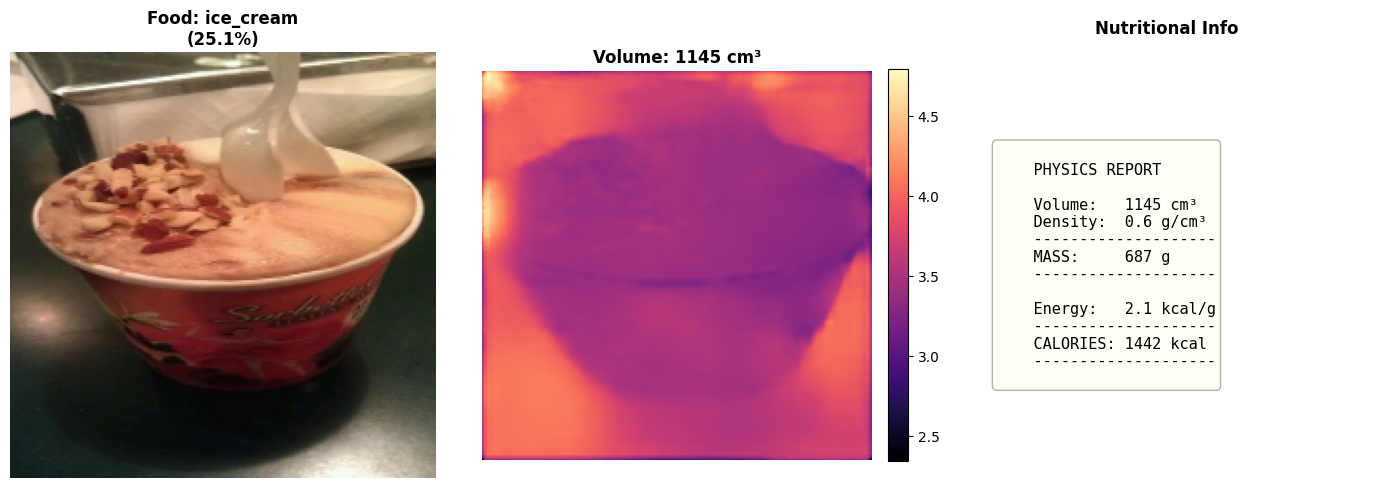

   ✅ Saved to 'nutrition_result.png'

✅ RESULT: ice_cream | 1145 cm³ | 687g | 1442 kcal



In [29]:
import random
import os

# Get the root directory and split info
root = valid_ds._base_folder  # Food101 stores path here
sample_idx = random.randint(0, len(valid_ds) - 1)

# Get the image info from _labels and _image_files
sample_path = str(valid_ds._image_files[sample_idx])
print(f"Testing on: {sample_path}")

results = predict_meal_calories(sample_path, model, valid_ds.classes, DEVICE)

In [30]:
# Quick test to see depth value range
model.eval()
with torch.no_grad():
    sample_img = next(iter(valid_dl))[0][:1].to(DEVICE)
    class_out, depth_out = model(sample_img, return_depth=True)
    print(f"Depth min: {depth_out.min().item():.4f}")
    print(f"Depth max: {depth_out.max().item():.4f}")
    print(f"Depth mean: {depth_out.mean().item():.4f}")

Depth min: 2.1759
Depth max: 8.2224
Depth mean: 4.0110
